# Week5 세션 과제_ 오다건

### RNN

1. 순환구조 이루는 인공신경망의 한 종류.
2. 자료의 순서 고려 가능 => 시퀀스 데이터 처리에 적합
3. 은닉충을 한 번만 지나가는 것이 아니라, 다시 같은 은닉충으로 들어가도록. 
4. 모든 셀이 파라미터 공유. 
5. hidden state는 직전시점의 hidden state 받아서 갱신 -> 데이터 순서 이해 가능. 
6. gradient descent 이용해 학습, 하지만 순환구조 (아까 폴드된 구조) 가지고 있어서 Back-propagation Through Time 이라 부름.  => 이전 시간의 단계도 고려해야함.

7. 그런데, 데이터의 시쿼스가 짧다면 RNN은 과거의 정보 잘 이용하여 학습 가능. 그런데 시퀀스 길면 시점끼리의 차이가 크니까 성능 떨어질 수도 있음. => RNN의 장기의존성 문제. => Gradient Vanishing.

### LSTM

1. 표준 RNN 과 LSTM은 반복되는 모듈이 가지고 있는 신경망 레이어의 개수의 차이가 존재. (1 vs 4)
2. cell state: 선형 상호작용, 전체 체인 따라 직진. 정보 변하지 않음. 
3. LSTM - cell state 에 정보 추가하거나 제거할 수 있는 능력 => 그 구조가 Gate
4. Gating = 선택적으로 정보 통과시키는 방법 = sigmoid 신경망 레이어 vs pointwise multiplication operation. 

4-2. 시그모이드 레이어:  0은 "아무것도 통과시키지 말 것"를 의미하고, 1은 "모든 것을 통과시킬 것"을 의미
4-3. LSTM은 cell state 보호하고 통제하기 위한 게이트를 3개 가지고 있음. 

#### LSTM의 구조 

1. forget gate layer : cell state에 어떠한 정보 제거할 것인지. by 시그모이드 레이어. 
2. Input gate : cell state에 어떠한 새로운 정보 추가할 것인지 결정하는 단계.

2-1. input gate layer : 시그모이드가 어떠한 값 업데이트 할 것인지.
2-2. update gate layer :
2-3. 두가지 결합. 

3. Cell state: 새롭게 업데이트 
4. Output Gate : cell state 기반으로 필터링한 버전.



## 과제 1번)

In [1]:
import torch
import torch.optim as optim
import numpy as np


In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [3]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [4]:
# make dictionary
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}

In [5]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

In [6]:
# data setting
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

x_one_hot = [np.eye(dic_size)[x] for x in x_data]

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [7]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [8]:
# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x)
        return x


net = Net(dic_size, hidden_size, 2)

In [9]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [10]:
# start training
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        # print(i, j, ''.join([char_set[t] for t in result]), loss.item())
        if j == 0:
            predict_str += ''.join([char_set[t] for t in result])
        else:
            predict_str += char_set[result[-1]]

    print(predict_str)

fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
e                                                                                                                                                                                  
      tt   t tttt   tttt    tttt   ttt  t        ttt     tttttt      ttt  t   ttt     ttt       tt tttt   tt    ttt       ttt    tt   ttttt   ttt t   ttttt  tt     tt   t t   ttt 
                             o     o                                          oo                          o                o                                        o          oo  
                                                                                                                                                                                   
  tnnnnnnnndnnnnndnndndnndnndndnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnndnnnddddnndnnndnndnnnnnnnn

## 과제 2번

In [33]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)


In [34]:
print(findFiles('name_data/names/*.txt'))

['name_data/names/Czech.txt', 'name_data/names/German.txt', 'name_data/names/Arabic.txt', 'name_data/names/Japanese.txt', 'name_data/names/Chinese.txt', 'name_data/names/Vietnamese.txt', 'name_data/names/Russian.txt', 'name_data/names/French.txt', 'name_data/names/Irish.txt', 'name_data/names/English.txt', 'name_data/names/Spanish.txt', 'name_data/names/Greek.txt', 'name_data/names/Italian.txt', 'name_data/names/Portuguese.txt', 'name_data/names/Scottish.txt', 'name_data/names/Dutch.txt', 'name_data/names/Korean.txt', 'name_data/names/Polish.txt']


In [36]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;' "
n_letters = len(all_letters)

In [37]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )



In [38]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [42]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('name_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

#이제 각 category (언어)를 line (이름)에 매핑하는 사전인 category_lines 를 만들었습니다. 
#나중에 참조 할 수 있도록 all_categories (언어 목록)와 n_categories 도 추적합니다.



In [45]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [46]:
#모든 이름을 체계화 했으니, Tensor로 전환하여 활용하자. 원 핫 벡터 사용!
#단어 만들기 위해 원 핫 벡터들을 2차원 행렬에 결합시킵니다.

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
torch.Size([5, 1, 58])


In [47]:
# 네트워크 생성

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [48]:
# 한 단계 실행하려면 현재 문자 tesnor - 입력과 이전의 은닉상태 전달해야함. 그다음 폴드 형태니까
#출력과 다음 은닉상태를 돌려받음. 

input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [49]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8297, -2.9376, -2.8851, -2.9093, -2.9364, -2.9763, -2.8471, -2.8367,
         -2.9292, -2.8780, -2.8967, -2.8499, -2.7856, -2.8677, -3.0035, -2.8569,
         -2.8324, -3.0008]], grad_fn=<LogSoftmaxBackward>)


In [50]:
#가장 확률이 높은 카테고리 (언어) 반환

def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 12)


In [51]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Richelieu
category = English / line = Tempest
category = German / line = Schwarzenegger
category = Vietnamese / line = Vuong
category = Portuguese / line = Gomes
category = Greek / line = Dritsas
category = Japanese / line = Murase
category = Spanish / line = Alamilla
category = Italian / line = Lombardi
category = Italian / line = Viola


#### 네트워크 학습

입력과 목표 Tensor 생성

0 로 초기화된 은닉 상태 생성

각 문자를 읽기

다음 문자를 위한 은닉 상태 유지

목표와 최종 출력 비교

역전파

출력과 손실 반환


In [52]:
criterion = nn.NLLLoss()


In [53]:
learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [54]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.8110 Mackay / English ✗ (Scottish)
10000 10% (0m 14s) 1.6078 Bukoski / Polish ✓
15000 15% (0m 22s) 1.8890 Espina / Italian ✗ (Spanish)
20000 20% (0m 30s) 0.7674 Schneiders / Dutch ✓
25000 25% (0m 38s) 0.8296 Pan / Chinese ✓
30000 30% (0m 46s) 0.6132 Bobienski / Polish ✓
35000 35% (0m 55s) 1.0629 Tselobenok / Greek ✗ (Russian)
40000 40% (1m 4s) 0.7318 Paulissen / Dutch ✓
45000 45% (1m 13s) 4.8307 Lis / Chinese ✗ (Polish)
50000 50% (1m 22s) 0.4672 O'Donoghue / Irish ✓
55000 55% (1m 29s) 2.1711 Batt / German ✗ (English)
60000 60% (1m 37s) 0.7862 Romano / Italian ✓
65000 65% (1m 44s) 1.9972 Connor / Portuguese ✗ (English)
70000 70% (1m 52s) 2.8432 Cerny / English ✗ (Czech)
75000 75% (1m 59s) 0.5604 Khouri / Arabic ✓
80000 80% (2m 7s) 0.1426 Lillis / Greek ✓
85000 85% (2m 14s) 3.9473 Vipper / French ✗ (Russian)
90000 90% (2m 22s) 0.5060 Ritchie / Scottish ✓
95000 95% (2m 29s) 0.7799 Schreck / German ✓
100000 100% (2m 37s) 0.4089 Zharkikh / Russian ✓


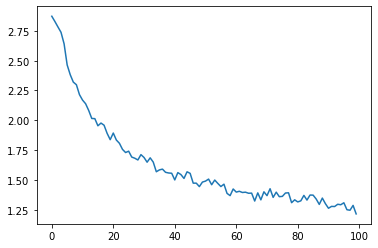

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

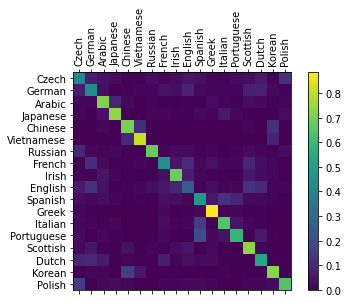

In [56]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [57]:
#주축에서 벗어난 친구들 중 (한국어를 중국어로 인식했다던가) 표시해보기

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.75) Czech
(-0.89) Russian
(-2.99) Polish

> Jackson
(-0.76) Scottish
(-1.43) English
(-1.70) Russian

> Satoshi
(-0.70) Japanese
(-1.44) Italian
(-2.44) Arabic
